# Third iteration ( TimeSeries method )

The Long Short-Term Memory (LSTM) network in Keras supports time steps.

This raises the question as to whether lag observations for a univariate time series can be used as time steps for an LSTM and whether or not this improves forecast performance.

In this tutorial, we will investigate the use of lag observations as time steps in LSTMs models in Python.

## Load the Data

In [69]:
#Import the necessary libraries
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from pandas.plotting import scatter_matrix
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.model_selection import train_test_split

# create scorer
scorer = make_scorer(mean_absolute_error)

# Load Iquitos preprocessed Data 
features_train_iq = pd.read_csv("preprocessed data/dengue_features_train_iq.csv")
labels_train_iq = pd.read_csv("preprocessed data/dengue_labels_train_iq.csv")
features_test_iq = pd.read_csv("preprocessed data/dengue_features_test_iq.csv")

# drop all columns referencing times
stripped_features_train_iq = features_train_iq.drop(['year','weekofyear','week_start_date'], axis=1)
stripped_labels_train_iq = labels_train_iq.drop(['year','weekofyear'], axis=1)
stripped_features_test_iq = features_test_iq.drop(['year','weekofyear','week_start_date'], axis=1)

# Load San Juan preprocessed Data 
features_train_sj = pd.read_csv("preprocessed data/dengue_features_train_sj.csv")
labels_train_sj = pd.read_csv("preprocessed data/dengue_labels_train_sj.csv")
features_test_sj = pd.read_csv("preprocessed data/dengue_features_test_sj.csv")

stripped_features_train_sj = features_train_sj.drop(['year','weekofyear','week_start_date'], axis=1)
stripped_labels_train_sj = labels_train_sj.drop(['year','weekofyear'], axis=1)
stripped_features_test_sj = features_test_sj.drop(['year','weekofyear','week_start_date'], axis=1)

In [70]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
        indexes of removed rows

    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg


# auxiliar function that receives three sets of data and applies window method conversion
def prepare_data_with_window (data_train, data_labels, data_test, window_size):
    
    data = data_train.append(data_test)
    
    data_w = series_to_supervised(data, n_in=window_size, dropnan=True)
    
    #split
    data_train_w = data_w.iloc[ : (len(data_train) - window_size)]
    data_test_w = data_w.iloc[(len(data_train) - window_size) : ]
    data_labels_w = data_labels.iloc[window_size : ]
    
    return data_train_w, data_labels_w, data_test_w


# initialize variables
window_size = 12
time_steps = window_size + 1
n_features = stripped_features_train_iq.shape[1]

# prepare Iquitos dataset with a window of given size 
w_stripped_features_train_iq, w_stripped_labels_train_iq, w_stripped_features_test_iq = prepare_data_with_window(
    stripped_features_train_iq, 
    stripped_labels_train_iq, 
    stripped_features_test_iq, window_size)

# necessary because when preparing data with window method,the first n (window size) samples 
# should be removed  because of NaN values
w_features_train_iq = features_train_iq.iloc[window_size : ]
w_labels_train_iq = labels_train_iq.iloc[window_size : ]


# prepare San Juan dataset with a window of given size 
w_stripped_features_train_sj, w_stripped_labels_train_sj, w_stripped_features_test_sj = prepare_data_with_window(
    stripped_features_train_sj, 
    stripped_labels_train_sj, 
    stripped_features_test_sj, window_size)

# necessary because when preparing data with window method,the first n (window size) samples 
# should be removed  because of NaN values
w_features_train_sj = features_train_sj.iloc[window_size : ]
w_labels_train_sj = labels_train_sj.iloc[window_size : ]


## Long Short-Term Memory (LSTM)

### Initialization

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.regularizers import L1L2

reg = L1L2(l1=0.0, l2=0.00001)
#reg = L1L2(l1=0.0, l2=0.00)

columns_to_scale = w_stripped_features_test_iq.columns.difference(['data_set'])

# Initialize a scaler and apply it to the features
scaler = MinMaxScaler(feature_range=(0, 1)) # default=(0, 1)

### Iquitos

In [72]:
# Normalization should be done on both, train and test features datasets, ensuring that the values in both datasets 
# remain of same magnitude. Therefore these datasets will be joined, applied the minmax normalization, and then splitted.
w_stripped_features_train_iq['data_set'] = 'train'
w_stripped_features_test_iq['data_set']  = 'simulate'

dengue_norm_features_iq  = w_stripped_features_train_iq.append(w_stripped_features_test_iq)
dengue_norm_features_iq[columns_to_scale] = scaler.fit_transform(dengue_norm_features_iq[columns_to_scale])

# separate into the original datasets, dropping the temporary columns 'dataset'
stripped_norm_dengue_features_train_iq = dengue_norm_features_iq[dengue_norm_features_iq['data_set'] == 'train']
stripped_norm_dengue_features_train_iq = stripped_norm_dengue_features_train_iq.reset_index(drop = True)
stripped_norm_dengue_features_train_iq = stripped_norm_dengue_features_train_iq.drop(['data_set'], axis=1)

stripped_norm_dengue_features_test_iq = dengue_norm_features_iq[dengue_norm_features_iq['data_set'] == 'simulate']
stripped_norm_dengue_features_test_iq = stripped_norm_dengue_features_test_iq.reset_index(drop = True)
stripped_norm_dengue_features_test_iq = stripped_norm_dengue_features_test_iq.drop(['data_set'], axis=1)

# normalize labels
scalerLabels_iq = scaler.fit(w_stripped_labels_train_iq)
stripped_norm_dengue_labels_train_iq = scalerLabels_iq.transform(w_stripped_labels_train_iq)

# split data into train and test
X_train, X_test = np.split(stripped_norm_dengue_features_train_iq, [int(.8*len(stripped_norm_dengue_features_train_iq))])
y_train, y_test = np.split(stripped_norm_dengue_labels_train_iq, [int(.8*len(stripped_norm_dengue_labels_train_iq))])

# convert dataframe to array
X_train = X_train.values
X_test = X_test.values
X_submission = stripped_norm_dengue_features_test_iq.values

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], time_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], time_steps, n_features))
X_submission = X_submission.reshape((X_submission.shape[0], time_steps, n_features))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#design network
model = Sequential()
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(240, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mse', optimizer='adam')

(399, 13, 6) (399, 1) (100, 13, 6) (100, 1)


In [73]:
# train model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.it3.iq.hdf5', verbose=2, 
                               save_best_only=True)

# fit network       
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=0, shuffle=False,
                    callbacks=[checkpointer])

Epoch 00001: val_loss improved from inf to 0.01388, saving model to saved_models/weights.best.it3.iq.hdf5
Epoch 00002: val_loss improved from 0.01388 to 0.01314, saving model to saved_models/weights.best.it3.iq.hdf5
Epoch 00003: val_loss improved from 0.01314 to 0.01178, saving model to saved_models/weights.best.it3.iq.hdf5
Epoch 00004: val_loss improved from 0.01178 to 0.01168, saving model to saved_models/weights.best.it3.iq.hdf5
Epoch 00005: val_loss improved from 0.01168 to 0.01100, saving model to saved_models/weights.best.it3.iq.hdf5
Epoch 00006: val_loss improved from 0.01100 to 0.01095, saving model to saved_models/weights.best.it3.iq.hdf5
Epoch 00007: val_loss improved from 0.01095 to 0.01083, saving model to saved_models/weights.best.it3.iq.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 

Epoch 00191: val_loss did not improve
Epoch 00192: val_loss did not improve
Epoch 00193: val_loss did not improve
Epoch 00194: val_loss did not improve
Epoch 00195: val_loss did not improve
Epoch 00196: val_loss did not improve
Epoch 00197: val_loss did not improve
Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200: val_loss did not improve


In [74]:
# load best weights
model.load_weights('saved_models/weights.best.it3.iq.hdf5')

# make a prediction
y_submission = model.predict(X_submission)

# invert scaling for forecast
y_submission = scalerLabels_iq.inverse_transform(y_submission)
y_submission_iq = np.around(y_submission, decimals=0)
y_submission_iq = y_submission_iq.astype(int)

### San Juan

In [75]:
# Normalization should be done on both, train and test features datasets, ensuring that the values in both datasets 
# remain of same magnitude. Therefore these datasets will be joined, applied the minmax normalization, and then splitted.
w_stripped_features_train_sj['data_set'] = 'train'
w_stripped_features_test_sj['data_set']  = 'simulate'

dengue_norm_features_sj  = w_stripped_features_train_sj.append(w_stripped_features_test_sj)
dengue_norm_features_sj[columns_to_scale] = scaler.fit_transform(dengue_norm_features_sj[columns_to_scale])

# separate into the original datasets, dropping the temporary columns 'dataset'
stripped_norm_dengue_features_train_sj = dengue_norm_features_sj[dengue_norm_features_sj['data_set'] == 'train']
stripped_norm_dengue_features_train_sj = stripped_norm_dengue_features_train_sj.reset_index(drop = True)
stripped_norm_dengue_features_train_sj = stripped_norm_dengue_features_train_sj.drop(['data_set'], axis=1)

stripped_norm_dengue_features_test_sj = dengue_norm_features_sj[dengue_norm_features_sj['data_set'] == 'simulate']
stripped_norm_dengue_features_test_sj = stripped_norm_dengue_features_test_sj.reset_index(drop = True)
stripped_norm_dengue_features_test_sj = stripped_norm_dengue_features_test_sj.drop(['data_set'], axis=1)

# normalize labels
scalerLabels_sj = scaler.fit(w_stripped_labels_train_sj)
stripped_norm_dengue_labels_train_sj = scalerLabels_sj.transform(w_stripped_labels_train_sj)

# split data into train and test
X_train, X_test = np.split(stripped_norm_dengue_features_train_sj, [int(.8*len(stripped_norm_dengue_features_train_sj))])
y_train, y_test = np.split(stripped_norm_dengue_labels_train_sj, [int(.8*len(stripped_norm_dengue_labels_train_sj))])

# convert dataframe to array
X_train = X_train.values
X_test = X_test.values
X_submission = stripped_norm_dengue_features_test_sj.values

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], time_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], time_steps, n_features))
X_submission = X_submission.reshape((X_submission.shape[0], time_steps, n_features))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#design network
model = Sequential()
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(240, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu', kernel_regularizer=reg))
model.add(LSTM(120, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=reg))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mse', optimizer='adam')

(732, 13, 6) (732, 1) (184, 13, 6) (184, 1)


In [76]:
# fit network
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.it3.sj.hdf5', verbose=2, 
                               save_best_only=True)
        
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=0, shuffle=False,
                    callbacks=[checkpointer])

Epoch 00001: val_loss improved from inf to 0.00737, saving model to saved_models/weights.best.it3.sj.hdf5
Epoch 00002: val_loss improved from 0.00737 to 0.00590, saving model to saved_models/weights.best.it3.sj.hdf5
Epoch 00003: val_loss improved from 0.00590 to 0.00570, saving model to saved_models/weights.best.it3.sj.hdf5
Epoch 00004: val_loss improved from 0.00570 to 0.00426, saving model to saved_models/weights.best.it3.sj.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.00426 to 0.00367, saving model to saved_models/weights.best.it3.sj.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 0.00367 to 0.00365, saving model to saved_models/weights.best.it3.sj.hdf5
Epoch 00010: val_loss improved from 0.00365 to 0.00341, saving model to saved_models/weights.best.it3.sj.hdf5
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss improved from 0.00341 

Epoch 00193: val_loss did not improve
Epoch 00194: val_loss did not improve
Epoch 00195: val_loss did not improve
Epoch 00196: val_loss did not improve
Epoch 00197: val_loss did not improve
Epoch 00198: val_loss did not improve
Epoch 00199: val_loss did not improve
Epoch 00200: val_loss did not improve


In [77]:
# load best weights
model.load_weights('saved_models/weights.best.it3.sj.hdf5')

# make a prediction
y_submission = model.predict(X_submission)

# invert scaling for forecast
y_submission = scalerLabels_iq.inverse_transform(y_submission)
y_submission_sj = np.around(y_submission, decimals=0)
y_submission_sj = y_submission_sj.astype(int)

### Create LSTM Submission File

In [78]:
# San Juan - city,year,weekofyear,total_cases
submission_sj = features_test_sj[['year','weekofyear']]
submission_sj.insert( 0,'city','sj')

df_y_submission_sj = pd.DataFrame(y_submission_sj, columns=['total_cases'])
submission_sj = pd.concat([submission_sj, df_y_submission_sj], axis=1)

# Iquitos - city,year,weekofyear,total_cases
submission_iq = features_test_iq[['year','weekofyear']]
submission_iq.insert( 0,'city','iq')

df_y_submission_iq = pd.DataFrame(y_submission_iq, columns=['total_cases'])
submission_iq = pd.concat([submission_iq, df_y_submission_iq], axis=1)

# join both predictions
submission = pd.concat([submission_sj, submission_iq])
submission = submission.reset_index(drop = True)

#write into csv
submission.to_csv("Submission/Submission_it3_lstm_b32_L2_w12.csv", encoding='utf-8', index=False)

#### With kernel regularizer L2 (0.00001),  Batch Size 16 and Window Size 8:

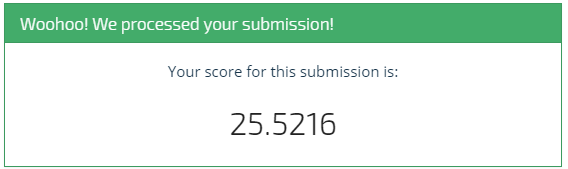

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 10:
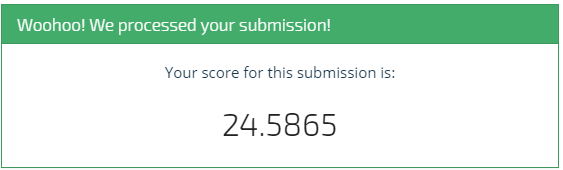

#### With kernel regularizer L2 (0.00001),  Batch Size 32 and Window Size 12:
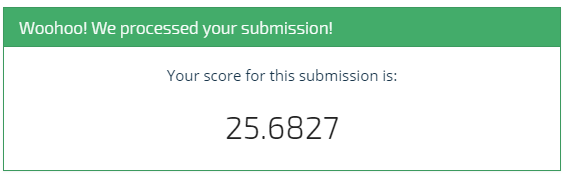